In [2]:
%run ../_preamble.ipynb
from _work.src.modules import AutoEncoder, train_model, plot_metrics, plot_tensor, eval_model, get_distances, get_closest_item
from _work.src.modules.replay import get_attractors, iterate
from _work.src.modules.utils import save_metrics, load_metrics
from _work.src.data import small_dataloader as dataloader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

palette = {
    'Oak': '#B0E65A',
    'Pine': '#75993C',
    'Daisy': '#FEB756',
    'Rose': '#E6634E',
    'Salmon': '#9194E3',
    'Sunfish': '#8BCBD9',
    'Canary': '#FFD92F',
    'Robin': '#FF8C9A',
}

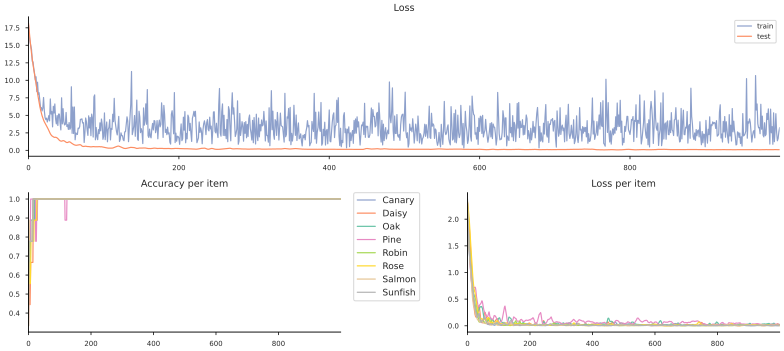

In [3]:
metrics1 = train_model(
    model1 := AutoEncoder(sizes=[dataloader.dataset.NUM_ATTRIBUTES, 32], batch_norm=False, dropout=0),
    optimizer1 := torch.optim.AdamW(model1.parameters(), lr=1e-2),
    loss_fn1 := torch.nn.MSELoss(reduction="sum"),
    dataloader,
    epochs=1000,
    noise_mean=0,
    noise_stdev=1,
    noise_multiplier=0.5,
    l1_lambda=0.0005,
)

plot_metrics(metrics1);

In [4]:
from torch.utils.data import Dataset, DataLoader
from _work.src.modules.replay import iterate

def generate_patterns(model, n_runs=1, n_steps=10, take_last=1, mean=0, stdev=1, multiplier=1):
    assert take_last <= n_steps

    states, _ = iterate(model, runs=n_runs, steps=n_steps, mean=mean, stdev=stdev, multiplier=multiplier)
    states = torch.vstack(tuple(states[:, -take_last:, :]))

    return states # n_runs * take_last

def create_dataloaders(states, n_epochs):
    class ReplayDataset(Dataset):
        def __init__(self, data):
            super().__init__()
            self.data = data
        
        def __len__(self):
            return len(self.data)
        
        def __getitem__(self, i):
            return {
                'y': self.data[i],
            }

    dataloaders = []
    for _ in range(n_epochs):
        indices = np.random.choice(list(range(len(states))), size=8, replace=False)
        data = ReplayDataset(states[indices])
        dl = DataLoader(data, shuffle=True, batch_size=4)
        dataloaders.append(dl)
    
    return dataloaders

In [5]:
def make_runs(
    name="test",
    n_runs=10,
    n_epochs=500,
    hidden_size=2,
    batch_norm=False,
    l1_lambda=0.0005,
    dropout=0,
    lr=1e-2,
    noise_mean=None,
    noise_stdev=None,
    noise_multiplier=None,
    **kwargs,
):
    # total_counts = { k: [] for k in dataloader.dataset.df.index }
    m = []

    for i in range(n_runs):
        # counts = { k: 0 for k in dataloader.dataset.df.index }
        dataloaders = create_dataloaders(
            patterns := generate_patterns(
                model1,
                n_runs=5000,
                n_steps=20,
                take_last=5,
                # mean=noise_mean,
                # stdev=noise_stdev,
                # multiplier=noise_multiplier,
                # mean=None,
                # stdev=None,
                # multiplier=None,
                **kwargs,
            ),
            n_epochs=n_epochs,
        )

        # for pattern in patterns:
        #     dists = get_distances(pattern, dataloader.dataset.df, metric='euclidean')
        #     item, dist = dists[0]
        #     counts[item] += 1

        metrics = train_model(
            model := AutoEncoder(
                sizes=[dataloader.dataset.NUM_ATTRIBUTES, hidden_size], batch_norm=batch_norm, dropout=dropout
            ),
            optimizer := torch.optim.AdamW(model.parameters(), lr=lr),
            loss_fn := torch.nn.MSELoss(reduction="sum"),
            dataloaders,
            test_loader=dataloader,
            epochs=n_epochs,
            noise_mean=noise_mean,
            noise_stdev=noise_stdev,
            noise_multiplier=noise_multiplier,
            l1_lambda=l1_lambda,
        )
        # save_metrics(metrics, f"{name}/{i}")
        m.append(metrics[0])
        # for item, count in counts.items():
        #     total_counts[item].append(count)

    return m
    # return m, total_counts
    # metrics = load_metrics(name)
    # return metrics, total_counts

def plot_indiv_loss(metrics):
    x = pd.DataFrame()
    for i, predictions in enumerate([m.predictions for m in metrics]):        
        new = predictions[['epoch', 'loss']].copy()
        new['item'] = new.index
        new['run'] = [i] * len(new)

        x = pd.concat([x, new])

    sns.lineplot(data=x, x="epoch", y="loss", hue='item', palette=palette)
    plt.xticks([*np.linspace(0, x['epoch'].max() + 1, num=7)])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    order = [*map(lambda x: x[0], sorted(enumerate(labels), key=lambda x: [*palette.keys()].index(x[1])))]
    handles = [*map(lambda x: x[1], sorted(enumerate(handles), key=lambda x: order.index(x[0])))]
    labels = [*map(lambda x: x[1], sorted(enumerate(labels), key=lambda x: order.index(x[0])))]
    plt.legend(handles=handles, labels=[x.capitalize() for x in labels])

In [6]:
def ttt(params):
    name = f"2_over_1_over,3_5000_5,{'_'.join([str(x) for x in params.values()])}"
    metrics = make_runs(name=name, **params)
    plot_indiv_loss(metrics);
    plt.savefig(f"../plots/{name.replace('.', ',')}")

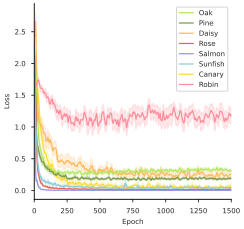

In [7]:
ttt({
    'n_runs': 25,
    'n_epochs': 1500,
    'hidden_size': 32,
    'noise_mean': 0,
    'noise_stdev': 1,
    'noise_multiplier': 0.5,
    'batch_norm': False,
    'l1_lambda': 0.0005,
    'mean': None,
    'stdev': None,
})

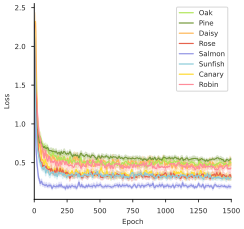

In [8]:
ttt({
    'n_runs': 25,
    'n_epochs': 1500,
    'hidden_size': 32,
    'noise_mean': 0,
    'noise_stdev': 1,
    'noise_multiplier': 0.5,
    'batch_norm': False,
    'l1_lambda': 0.0005,
    'mean': 0,
    'stdev': 1,
    'multiplier': 1,
})

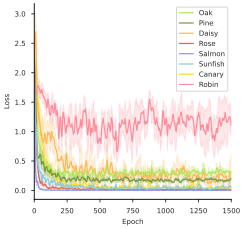

In [7]:
params = {
    'n_runs': 5,
    'n_epochs': 1500,
    'hidden_size': 32,
    'noise_mean': 0,
    'noise_stdev': 1,
    'noise_multiplier': 0.5,
    'batch_norm': False,
    'l1_lambda': 0.0005,
    'mean': None,
    'stdev': None,
}

name = f"2_over_1_over,5000_5,{'_'.join([str(x) for x in params.values()])}"
metrics = make_runs(name=name, **params)
plot_indiv_loss(metrics);
# plt.savefig(f"../plots/{name.replace('.', ',')}")
# make_runs(name=name, **params)

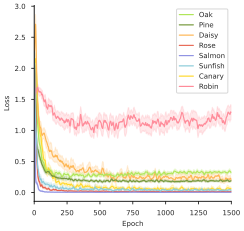

In [7]:
params = {
    'n_runs': 25,
    'n_epochs': 1500,
    'hidden_size': 32,
    'noise_mean': 0,
    'noise_stdev': 1,
    'noise_multiplier': 0.5,
    'batch_norm': False,
    'l1_lambda': 0.0005,
    'mean': None,
    'stdev': None,
}

name = f"2_over_1_over,2_5000_5,{'_'.join([str(x) for x in params.values()])}"
metrics = make_runs(name=name, **params)
plot_indiv_loss(metrics);
plt.savefig(f"../plots/{name.replace('.', ',')}")

In [8]:
params = {
    'n_runs': 25,
    'n_epochs': 1500,
    'hidden_size': 32,
    'noise_mean': 0,
    'noise_stdev': 1,
    'noise_multiplier': 0.5,
    'batch_norm': False,
    'l1_lambda': 0.0005,
    'mean': 0,
    'stdev': 1,
    'multiplier': 1,
}

name = f"2_over_1_over,2_5000_5,{'_'.join([str(x) for x in params.values()])}"
metrics = make_runs(name=name, **params)
plot_indiv_loss(metrics);
plt.savefig(f"../plots/{name.replace('.', ',')}")
# make_runs(name=name, **params)

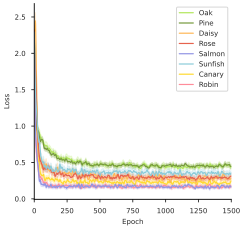

In [8]:
params = {
    'n_runs': 25,
    'n_epochs': 1500,
    'hidden_size': 32,
    'noise_mean': 0,
    'noise_stdev': 1,
    'noise_multiplier': 0.5,
    'batch_norm': False,
    'l1_lambda': 0.0005,
    'mean': 0,
    'stdev': 1,
    'multiplier': 0.5,
}

name = f"2_over_1_over_{'_'.join([str(x) for x in params.values()])}"
metrics = load_metrics(name)
plot_indiv_loss(metrics);
plt.savefig(f"../plots/{name.replace('.', ',')}")
# make_runs(name=name, **params)

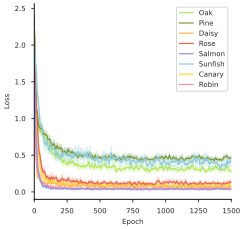

In [9]:
params = {
    'n_runs': 25,
    'n_epochs': 1500,
    'hidden_size': 32,
    'noise_mean': 0,
    'noise_stdev': 1,
    'noise_multiplier': 0.5,
    'batch_norm': False,
    'l1_lambda': 0.0005,
    'mean': 0,
    'stdev': 1,
    'multiplier': 0.25,
}

name = f"2_over_1_over_{'_'.join([str(x) for x in params.values()])}"
metrics = load_metrics(name)
plot_indiv_loss(metrics);
plt.savefig(f"../plots/{name.replace('.', ',')}")
# make_runs(name=name, **params)

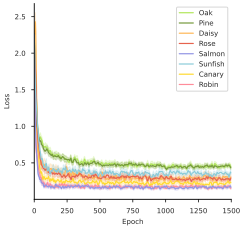

In [10]:
params = {
    'n_runs': 25,
    'n_epochs': 1500,
    'hidden_size': 32,
    'noise_mean': 0,
    'noise_stdev': 1,
    'noise_multiplier': 0.5,
    'batch_norm': False,
    'l1_lambda': 0.0005,
    'mean': 0,
    'stdev': 0.5,
    'multiplier': 1,
}

name = f"2_over_1_over_{'_'.join([str(x) for x in params.values()])}"
metrics = load_metrics(name)
plot_indiv_loss(metrics);
plt.savefig(f"../plots/{name.replace('.', ',')}")
# make_runs(name=name, **params)

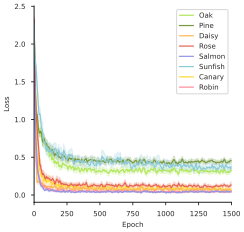

In [11]:
params = {
    'n_runs': 25,
    'n_epochs': 1500,
    'hidden_size': 32,
    'noise_mean': 0,
    'noise_stdev': 1,
    'noise_multiplier': 0.5,
    'batch_norm': False,
    'l1_lambda': 0.0005,
    'mean': 0,
    'stdev': 0.5,
    'multiplier': 0.5,
}

name = f"2_over_1_over_{'_'.join([str(x) for x in params.values()])}"
metrics = load_metrics(name)
plot_indiv_loss(metrics);
plt.savefig(f"../plots/{name.replace('.', ',')}")
# make_runs(name=name, **params)

In [34]:
params = {
    'n_runs': 25,
    'n_epochs': 600,
    'hidden_size': 32,
    'noise_mean': 0,
    'noise_stdev': 1,
    'noise_multiplier': 0.5,
    'batch_norm': False,
    'l1_lambda': 0.0005,
}

name = f"2_over_1_over_nonoise_{'_'.join([str(x) for x in params.values()])}"

metrics, noise_counts = make_runs(name=name, **params)

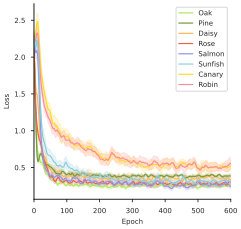

In [39]:
params = {
    'n_runs': 25,
    'n_epochs': 600,
    'hidden_size': 32,
    'noise_mean': 0,
    'noise_stdev': 1,
    'noise_multiplier': 0.5,
    'batch_norm': False,
    'l1_lambda': 0.0005,
    'mean': 0,
    'stdev': 1,
    'multiplier': 0.5,
}

name = f"2_over_1_over_nonoise_{'_'.join([str(x) for x in params.values()])}"

metrics, noise_counts = make_runs(name=name, **params)

plot_indiv_loss(metrics)
# plt.savefig('../plots/2_over_1_over_noise_20_5_0_1_0,5')

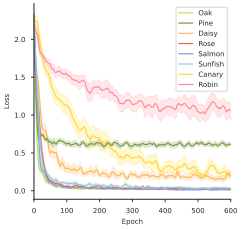

In [40]:
params = {
    'n_runs': 25,
    'n_epochs': 600,
    'hidden_size': 32,
    'noise_mean': 0,
    'noise_stdev': 1,
    'noise_multiplier': 0.5,
    'batch_norm': False,
    'l1_lambda': 0.0005,
    'mean': 0,
    'stdev': 1,
    'multiplier': 0.1,
}

name = f"2_over_1_over_noise_{'_'.join([str(x) for x in params.values()])}"

metrics, noise_counts = make_runs(name=name, **params)

plot_indiv_loss(metrics)
# plt.savefig('../plots/2_over_1_over_noise_20_5_0_1_0,1')

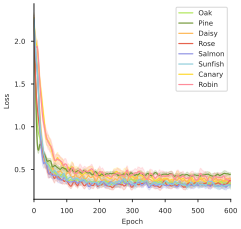

In [41]:
params = {
    'n_runs': 25,
    'n_epochs': 600,
    'hidden_size': 32,
    'noise_mean': 0,
    'noise_stdev': 1,
    'noise_multiplier': 0.5,
    'batch_norm': False,
    'l1_lambda': 0.0005,
    'mean': 0,
    'stdev': 1,
    'multiplier': 1,
}

name = f"2_over_1_over_noise_{'_'.join([str(x) for x in params.values()])}"

metrics, noise_counts = make_runs(name=name, **params)

plot_indiv_loss(metrics)
# plt.savefig('../plots/2_over_1_over_noise_20_5_0_1_1')

In [ ]:
generate_patterns(
    model1,
    n_runs=5,
    n_steps=20,
    take_last=5,
    mean=None,
    stdev=None,
    multiplier=None,
)

Error: Session cannot generate requests